# Generating Sample Data from Distributions
Then treating data as if they were samples of real data

* https://github.com/ijmbarr/causalgraphicalmodels
* https://github.com/ijmbarr/causalgraphicalmodels/blob/master/notebooks/cgm-examples.ipynb
* https://en.wikipedia.org/wiki/Vehicular_metrics

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

In [4]:
import pandas as pd
print(pd.__version__)

1.4.3


In [5]:
from scipy.stats import skewnorm

In [6]:
import seaborn as sns

In [7]:
# !pip install causalgraphicalmodels

In [8]:
# https://github.com/ijmbarr/causalgraphicalmodels
# https://github.com/ijmbarr/causalgraphicalmodels/blob/master/notebooks/cgm-examples.ipynb
from causalgraphicalmodels import StructuralCausalModel

In [9]:
# https://en.wikipedia.org/wiki/Vehicular_metrics

braking_distance_mean = 40
braking_distance_std = 5
power_mean = 100
power_std = 50

car_safety_model = StructuralCausalModel({
    "emergency_breaking": lambda n_samples: np.random.binomial(1, p=0.60, size=n_samples), 
    "braking_distance": lambda n_samples: np.random.normal(loc=braking_distance_mean, scale=braking_distance_std, size=n_samples),
    "power": lambda n_samples: skewnorm.rvs(a=2, loc=power_mean, scale=power_std, size=n_samples),
    "car_safety": \
        lambda emergency_breaking, braking_distance, power, n_samples: \
            np.random.normal(loc=emergency_breaking - \
                             # having a breaking distance below average is negative, so we have to subtract
                             (braking_distance - braking_distance_mean) / braking_distance_std - \
                             # all deviation from good amount of power is negative
                             abs(power - power_mean) / power_std, \
                             scale=0.1)
})

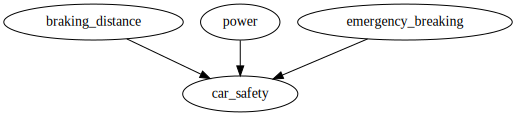

In [10]:
car_safety_model.cgm.draw()

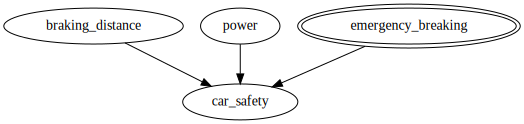

In [11]:
car_safety_model_do_emergency_breaking = car_safety_model.do("emergency_breaking")

car_safety_model_do_emergency_breaking.cgm.draw()

In [12]:
car_safety_model.cgm.get_distribution()

'P(emergency_breaking)P(braking_distance)P(power)P(car_safety|emergency_breaking,braking_distance,power)'

In [13]:
n_samples=10_000
# data = car_safety_model_do_emergency_breaking.sample(n_samples=n_samples, 
#                                                      set_values={"emergency_breaking": np.ones(n_samples)})
data = car_safety_model.sample(n_samples=n_samples)
data.head()

emergency_breaking  braking_distance       power  car_safety
0                   1         44.642188  122.865176   -0.189242
1                   1         36.398297  127.445292    1.218448
2                   0         41.237955  106.167312   -0.361591
3                   0         44.678406  160.368679   -2.192920
4                   1         37.908466  122.553468    0.942140

In [14]:
braking_distance = 31.983544

In [15]:
(braking_distance - braking_distance_mean) / braking_distance_std

-1.6032912000000004

In [16]:
power = 50

In [17]:
abs(power - power_mean) / power_std

1.0

In [18]:
data.describe()

emergency_breaking  braking_distance         power    car_safety
count        10000.000000      10000.000000  10000.000000  10000.000000
mean             0.596300         39.948680    135.359468     -0.185370
std              0.490663          5.046608     35.264507      1.276356
min              0.000000         22.084626     33.573422     -6.028485
25%              0.000000         36.537052    110.560310     -1.025860
50%              1.000000         39.951621    132.426662     -0.171113
75%              1.000000         43.326189    157.281936      0.692927
max              1.000000         57.969320    294.037953      4.448676

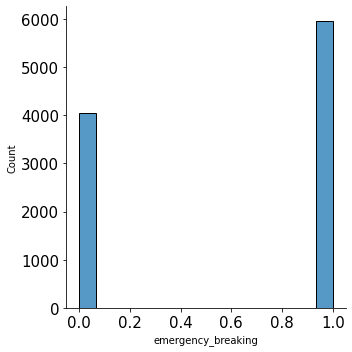

In [19]:
sns.displot(data["emergency_breaking"]);

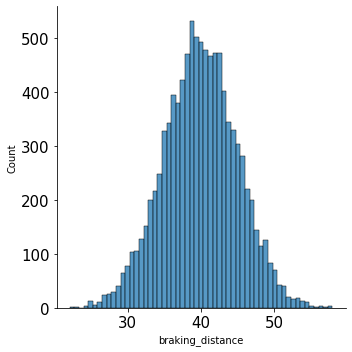

In [20]:
sns.displot(data["braking_distance"]);

In [21]:
sns.displot(data["power"]);

In [22]:
sns.displot(data["car_safety"]);

In [23]:
# sns.kdeplot?

In [24]:
sns.kdeplot(
    data=data["emergency_breaking"],
    data2=data["car_safety"],
    fill=True
);

In [25]:
sns.kdeplot(
    data=data["power"],
    data2=data["car_safety"],
    fill=True
);

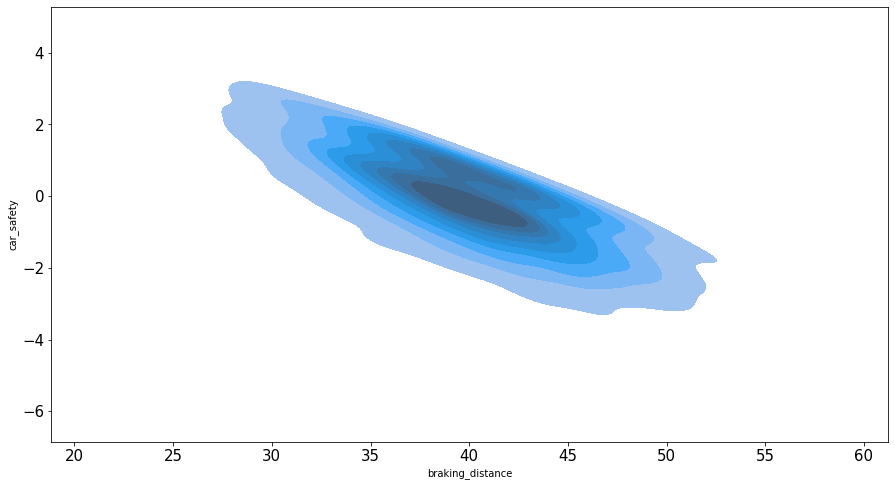

In [26]:
sns.kdeplot(
    data=data["braking_distance"],
    data2=data["car_safety"],
    fill=True
);

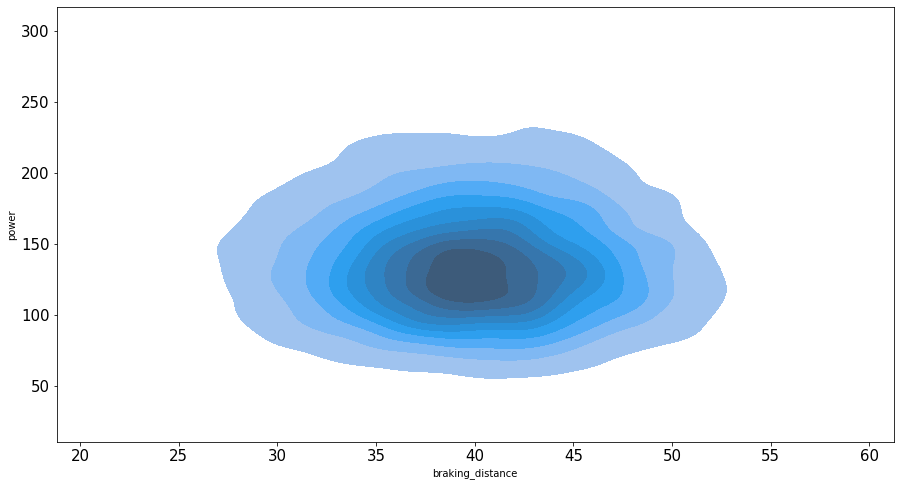

In [27]:
sns.kdeplot(
    data=data["braking_distance"],
    data2=data["power"],
    fill=True
);

In [28]:
from scipy.stats import pearsonr


In [29]:
# pearsonr?

In [30]:
r, p_value = pearsonr(data['braking_distance'], data['power'])
# The p-value roughly indicates the probability of an uncorrelated system
# producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.
r, p_value

(-0.004788565618865639, 0.6320813107218377)

In [31]:
r, p_value = pearsonr(data['braking_distance'], data['car_safety'])
r, p_value

(-0.7877194604006568, 0.0)

In [32]:
r, p_value = pearsonr(data['power'], data['car_safety'])
r, p_value

(-0.4354198776188608, 0.0)

# Driver's ability

age distribution: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/bevoelkerung-altersgruppen-deutschland.html

In [33]:
age_mean = 18
age_std = 22

x = skewnorm.rvs(a=8, loc=age_mean, scale=age_std, size=n_samples)
# hard clip leaves us with non constant amout of samples
# x = x[(x > 16) & (x < 100)] 
x = np.clip(x, a_min=16, a_max=100)
sns.displot(x);
x = x.astype(int)
age_skewed_mean = x.mean()
age_skewed_std = x.std()

x.min(), x.max(), age_skewed_mean, age_skewed_std, len(x)

(16, 100, 34.9514, 13.372226368110883, 10000)

In [34]:
driver_ability_model = StructuralCausalModel({
    "training": lambda n_samples: np.random.binomial(1, p=0.20, size=n_samples), 
    "age": lambda n_samples: skewnorm.rvs(a=16, loc=age_mean, scale=age_std, size=n_samples),
    "driver_ability": \
        lambda training, age, n_samples: 
            np.random.normal(loc=training - \
                             # all deviation from good age is negative
                             # using unskwed mean makes this a bit more balanaced
                             abs(age - age_skewed_mean) / age_std, \
                             scale=0.1)})

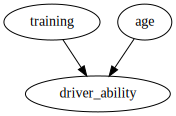

In [35]:
driver_ability_model.cgm.draw()

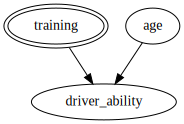

In [36]:
driver_ability_model_with_training = driver_ability_model.do("training")

driver_ability_model_with_training.cgm.draw()

In [37]:
driver_ability_model.cgm.get_distribution()

'P(training)P(age)P(driver_ability|training,age)'

In [38]:
n_samples=10_000
data = driver_ability_model.sample(n_samples=n_samples)
data.head()

training        age  driver_ability
0         0  41.760405       -0.387062
1         0  29.126453       -0.302831
2         0  18.759600       -0.817298
3         0  75.827291       -1.843940
4         1  20.420337        0.319753

In [39]:
age = 80

In [40]:
# abs(age - age_skewed_mean) / age_skewed_std
# more balanced
abs(age - age_skewed_mean) / age_std

2.0476636363636365

In [41]:
data.describe()

training           age  driver_ability
count  10000.000000  10000.000000    10000.000000
mean       0.199400     35.499929       -0.276274
std        0.399569     13.192871        0.548964
min        0.000000     14.865604       -3.106279
25%        0.000000     25.193821       -0.596888
50%        0.000000     32.829443       -0.326699
75%        0.000000     43.181522       -0.046062
max        1.000000    104.575415        1.239649

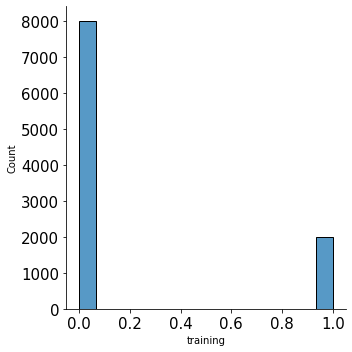

In [42]:
sns.displot(data["training"]);

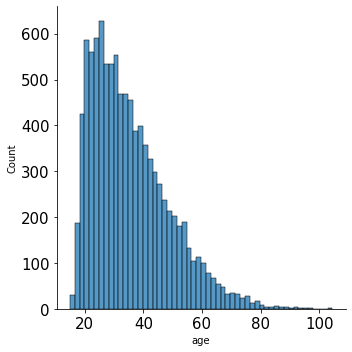

In [43]:
sns.displot(data["age"]);

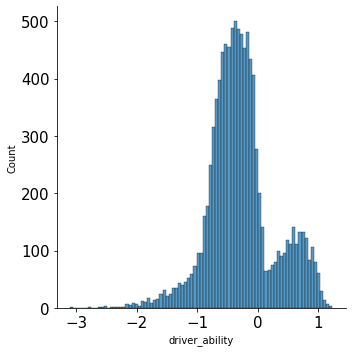

In [44]:
sns.displot(data["driver_ability"]);

In [45]:
# sns.kdeplot?

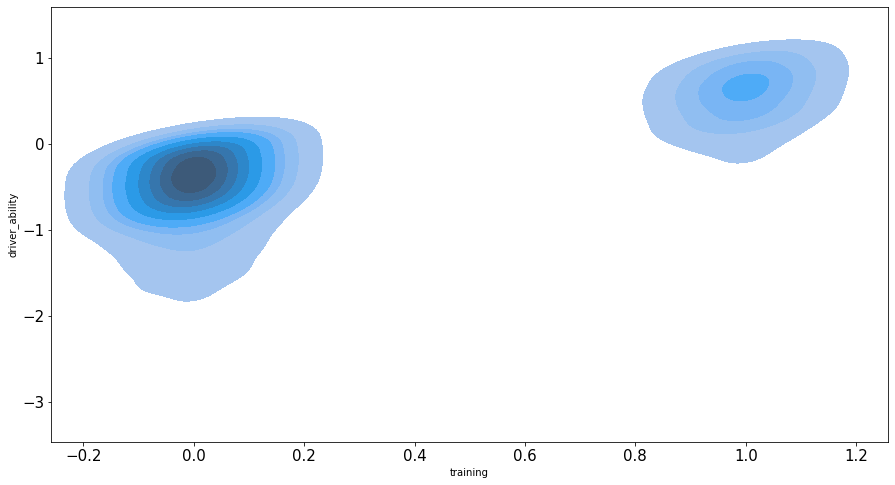

In [46]:
sns.kdeplot(
    data=data["training"],
    data2=data["driver_ability"],
    fill=True
);

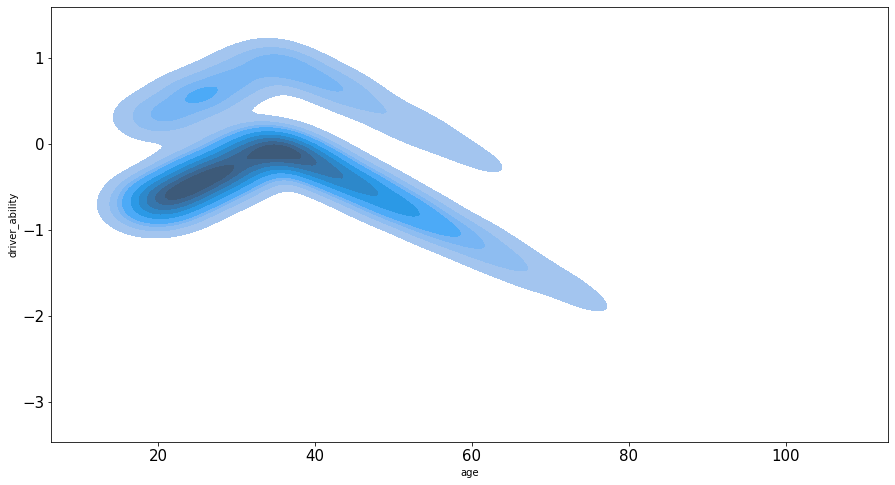

In [47]:
sns.kdeplot(
    data=data["age"],
    data2=data["driver_ability"],
    fill=True
);

In [48]:
r, p_value = pearsonr(data['age'], data['driver_ability'])
r, p_value

(-0.33315971382380655, 8.915017554081764e-258)

In [49]:
r, p_value = pearsonr(data['training'], data['driver_ability'])
r, p_value

(0.7251001152147941, 0.0)

In [50]:
r, p_value = pearsonr(data['training'], data['age'])
r, p_value

(0.004425987890760957, 0.6580944198207658)

# Combined risk model

In [51]:
from sklearn.preprocessing import normalize

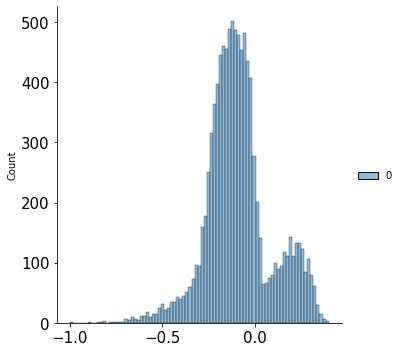

In [52]:
ability = normalize(data['driver_ability'].values.reshape(-1, 1), axis=0, norm='max')
sns.displot(ability);

(6.224664384261061, 126.67971051738512, 44.15169219551637, 15.76632376738184)

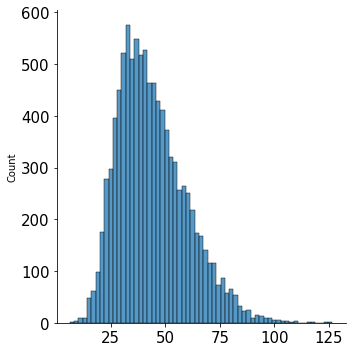

In [53]:
miles_mean = 25
miles_std = 25

x = skewnorm.rvs(a=4, loc=miles_mean, scale=miles_std, size=n_samples)
sns.displot(x);
miles_skewed_mean = x.mean()
miles_skewed_std = x.std()

x.min(), x.max(), miles_skewed_mean, miles_skewed_std

In [54]:
risk_model = StructuralCausalModel({
    "ability": lambda n_samples: driver_ability_model.sample(n_samples=n_samples)['driver_ability'], 
    "safety": lambda n_samples: car_safety_model.sample(n_samples=n_samples)['car_safety'],
    "miles": lambda n_samples: skewnorm.rvs(a=4, loc=miles_mean, scale=miles_std, size=n_samples),
    "risk": \
        lambda ability, safety, miles, n_samples:
                # negative score is high risk
             - np.random.normal(loc=ability + \
                             safety -
                             # all deviation from good miles is negative
                             abs(miles - miles_mean) / miles_std, \
                             scale=0.1)})

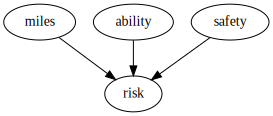

In [55]:
risk_model.cgm.draw()

In [56]:
n_samples=10_000
data = risk_model.sample(n_samples=n_samples)
data.head()

ability    safety      miles      risk
0 -0.572374  0.408103  73.471412  2.161018
1 -0.153162 -2.728192  31.452073  3.108073
2 -0.158379 -0.480274  26.636111  0.788602
3 -0.026770 -2.056975  27.755366  2.231908
4 -0.325496  1.256821  28.620698 -0.844794

In [57]:
data.describe()

ability        safety         miles          risk
count  10000.000000  10000.000000  10000.000000  10000.000000
mean      -0.289327     -0.196384     44.242785      1.276816
std        0.551361      1.271178     15.754878      1.510042
min       -2.897761     -5.062065      6.694929     -4.189968
25%       -0.610233     -1.025224     32.452612      0.239835
50%       -0.336663     -0.174197     41.623771      1.236415
75%       -0.058302      0.680627     53.599425      2.264322
max        1.254529      4.793812    125.440116      7.547765

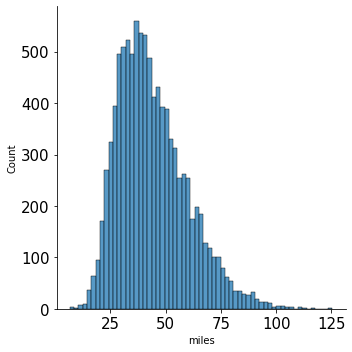

In [58]:
sns.displot(data["miles"]);

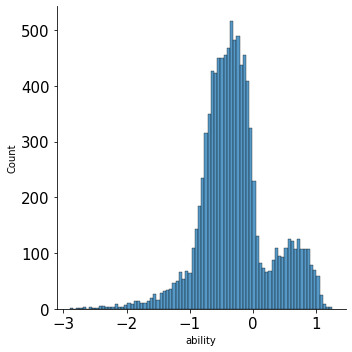

In [59]:
sns.displot(data["ability"]);

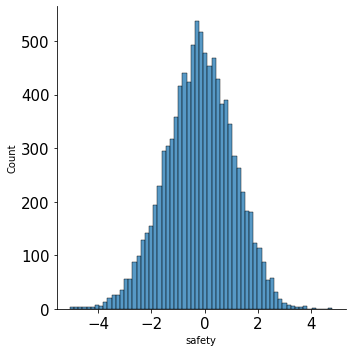

In [60]:
sns.displot(data["safety"]);

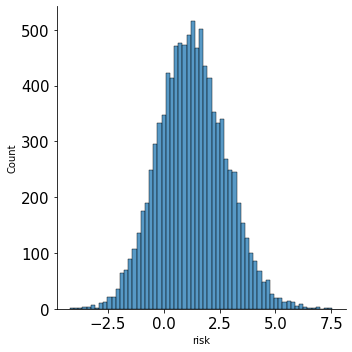

In [61]:
sns.displot(data["risk"]);

In [62]:
# sns.kdeplot?

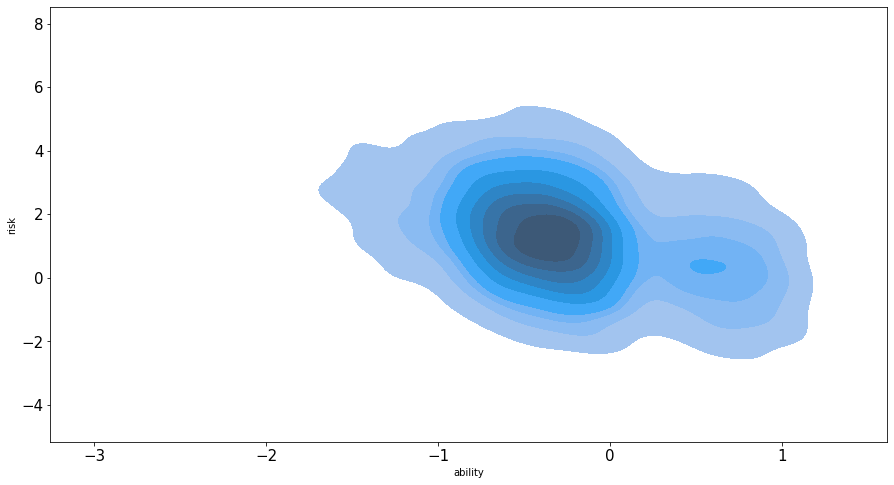

In [63]:
sns.kdeplot(
    data=data["ability"],
    data2=data["risk"],
    fill=True
);

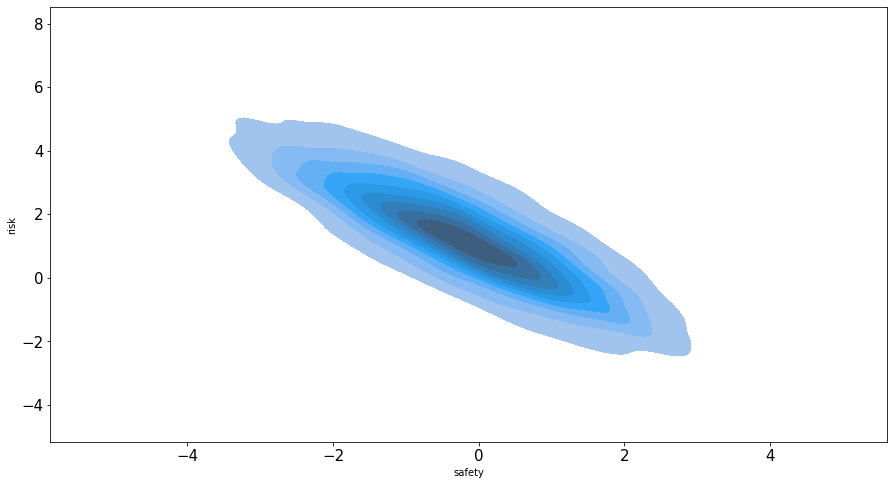

In [64]:
sns.kdeplot(
    data=data["safety"],
    data2=data["risk"],
    fill=True
);

In [65]:
r, p_value = pearsonr(data['safety'], data['risk'])
r, p_value

(-0.8395097905598364, 0.0)

In [66]:
r, p_value = pearsonr(data['ability'], data['risk'])
r, p_value

(-0.3734705995467459, 0.0)

In [67]:
r, p_value = pearsonr(data['ability'], data['safety'])
r, p_value

(0.012355357519135772, 0.2166710892000088)

# Decomposed combined

(16, 100, 34.9975, 13.360168178207939, 10000)

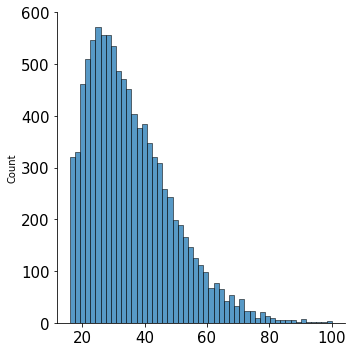

In [68]:
age_mean = 18
age_std = 22

x = skewnorm.rvs(a=8, loc=age_mean, scale=age_std, size=n_samples)
# hard clip leaves us with non constant amout of samples
# x = x[(x > 16) & (x < 100)] 
x = np.clip(x, a_min=16, a_max=100)
sns.displot(x);
x = x.astype(int)
age_skewed_mean = x.mean()
age_skewed_std = x.std()

x.min(), x.max(), age_skewed_mean, age_skewed_std, len(x)

In [69]:
# can be changed over time in favor of the car
# driver is overall more important than car
driver_weight = 4

risk_model = StructuralCausalModel({
    "training": lambda n_samples: np.random.binomial(1, p=0.20, size=n_samples), 
#     "age": lambda n_samples: np.clip(skewnorm.rvs(a=16, loc=age_mean, scale=age_std, size=n_samples), a_min=16, a_max=100).astype(int),
    "age": lambda n_samples: np.clip(skewnorm.rvs(a=16, loc=age_mean, scale=age_std, size=n_samples), a_min=16, a_max=100),
    "driver_ability": \
        lambda training, age, n_samples: 
            np.random.normal(loc=training - \
                             # all deviation from good age is negative
                             # using unskwed mean makes this a bit more balanaced
                             abs(age - age_skewed_mean) / age_std, \
                             scale=0.1),
    "emergency_breaking": lambda n_samples: np.random.binomial(1, p=0.40, size=n_samples), 
    "braking_distance": lambda n_samples: np.random.normal(loc=braking_distance_mean, scale=braking_distance_std, size=n_samples),
    "power": lambda n_samples: skewnorm.rvs(a=2, loc=power_mean, scale=power_std, size=n_samples),
    "car_safety": \
        lambda emergency_breaking, braking_distance, power, n_samples: \
            np.random.normal(loc=emergency_breaking - \
                             # having a breaking distance below average is negative, so we have to subtract
                             (braking_distance - braking_distance_mean) / braking_distance_std - \
                             # all deviation from good amount of power is negative
                             abs(power - power_mean) / power_std, \
                             scale=0.1),
    "miles": lambda n_samples: skewnorm.rvs(a=4, loc=miles_mean, scale=miles_std, size=n_samples),
    "risk": \
        lambda driver_ability, car_safety, miles, n_samples:
             # negative score is high risk
             - np.random.normal(loc=\
                             driver_ability * driver_weight\
                             + car_safety
                             # all deviation from good miles is negative
                             - abs(miles - miles_mean) / miles_std, \
                             scale=0.1)})

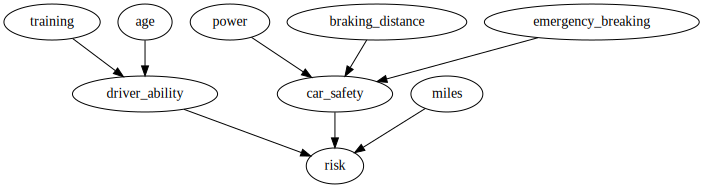

In [70]:
risk_model.cgm.draw()

In [71]:
# n_samples=10_000
n_samples=1_500
np.random.seed(42)
data = risk_model.sample(n_samples=n_samples)
data.head()

training        age  emergency_breaking  braking_distance       power  \
0         0  74.493138                   1         38.264068  122.527184   
1         1  67.074261                   0         43.854011  115.367900   
2         0  47.691471                   0         34.730823  126.498658   
3         0  55.429717                   0         42.139072  125.629252   
4         0  41.088408                   1         31.490489  241.447458   

       miles  driver_ability  car_safety      risk  
0  28.744236       -1.755792    0.803182  6.295961  
1  51.519687       -0.422205   -0.958545  3.772632  
2  52.320498       -0.661309    0.670282  3.062665  
3  54.241036       -1.045458   -0.821925  6.258721  
4  41.182762       -0.248701   -0.077803  1.786761

In [72]:
data.describe()

training          age  emergency_breaking  braking_distance  \
count  1500.000000  1500.000000         1500.000000       1500.000000   
mean      0.207333    35.243806            0.384667         39.728535   
std       0.405532    13.193059            0.486679          5.108156   
min       0.000000    16.000000            0.000000         25.502431   
25%       0.000000    24.971581            0.000000         36.261921   
50%       0.000000    32.511926            0.000000         39.697162   
75%       0.000000    43.043168            1.000000         43.284010   
max       1.000000    88.456666            1.000000         55.491497   

             power        miles  driver_ability   car_safety         risk  
count  1500.000000  1500.000000     1500.000000  1500.000000  1500.000000  
mean    137.524885    43.766704       -0.264698    -0.396552     2.225049  
std      36.527189    15.274232        0.545011     1.273974     2.576267  
min      31.956980     8.911590       -2.370182    -4.755363    -6.220299  
25%     112.369662    32.597446       -0.591373    -1.242621     0.572977  
50%     134.053456    41.697948       -0.310444    -0.377730     2.331219  
75%     160.117914    52.330167       -0.020692     0.495051     3.804784  
max     281.197004   106.746630        1.165727     3.637374    13.344780

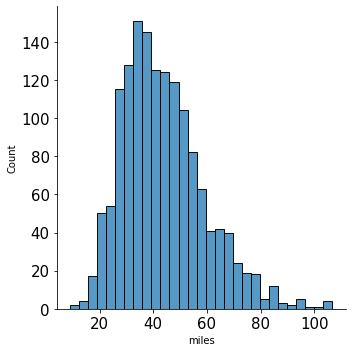

In [73]:
sns.displot(data["miles"]);

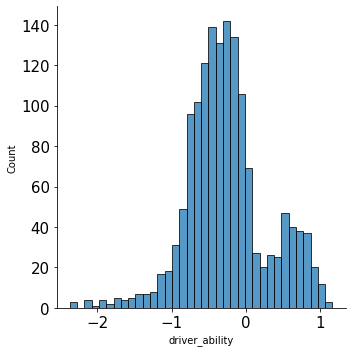

In [74]:
sns.displot(data["driver_ability"]);

In [75]:
sns.displot(data["car_safety"]);

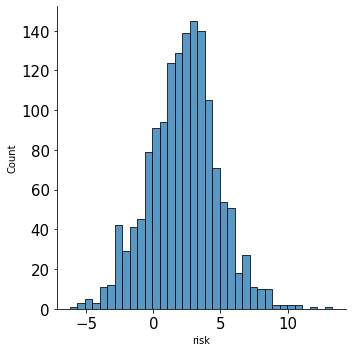

In [76]:
sns.displot(data["risk"]);

In [77]:
# sns.kdeplot?

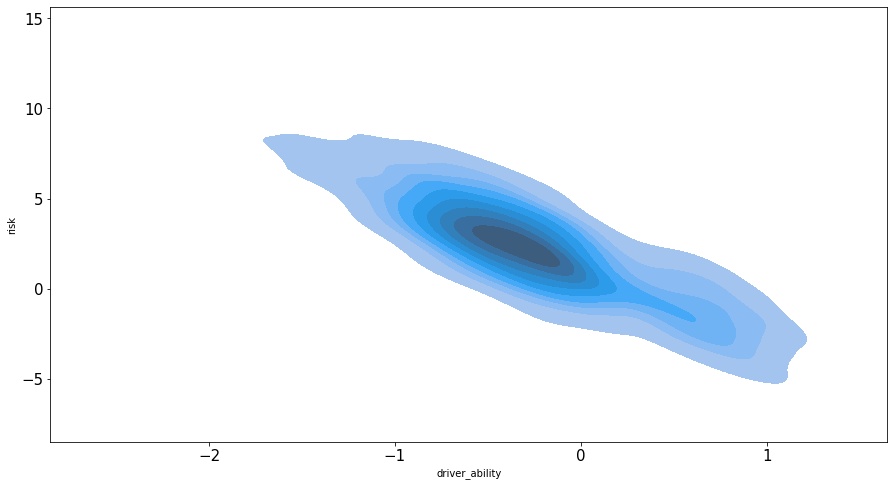

In [78]:
sns.kdeplot(
    data=data["driver_ability"],
    data2=data["risk"],
    fill=True
);

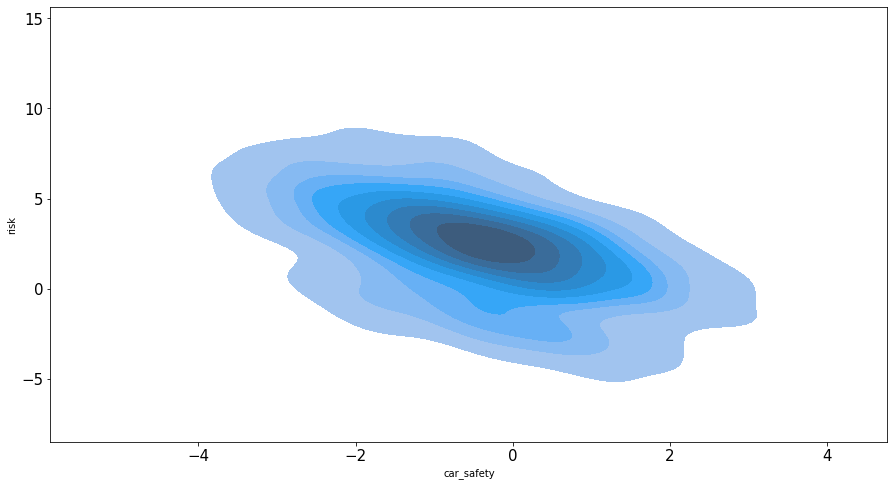

In [79]:
sns.kdeplot(
    data=data["car_safety"],
    data2=data["risk"],
    fill=True
);

In [80]:
r, p_value = pearsonr(data['car_safety'], data['risk'])
r, p_value

(-0.49494592800029147, 1.633893984624419e-93)

In [81]:
r, p_value = pearsonr(data['driver_ability'], data['risk'])
r, p_value

(-0.8363052569531675, 0.0)

In [82]:
r, p_value = pearsonr(data['driver_ability'], data['car_safety'])
r, p_value

(-0.0029502662091996272, 0.9091043714334741)

In [83]:
data.head()

training        age  emergency_breaking  braking_distance       power  \
0         0  74.493138                   1         38.264068  122.527184   
1         1  67.074261                   0         43.854011  115.367900   
2         0  47.691471                   0         34.730823  126.498658   
3         0  55.429717                   0         42.139072  125.629252   
4         0  41.088408                   1         31.490489  241.447458   

       miles  driver_ability  car_safety      risk  
0  28.744236       -1.755792    0.803182  6.295961  
1  51.519687       -0.422205   -0.958545  3.772632  
2  52.320498       -0.661309    0.670282  3.062665  
3  54.241036       -1.045458   -0.821925  6.258721  
4  41.182762       -0.248701   -0.077803  1.786761

In [84]:
GREEN = 2
YELLOW = 1
RED = 0

In [85]:
features = ['training', 'age', 'emergency_breaking', 'braking_distance', 'power', 'miles', 'risk']

In [86]:
# preprocessed_data = data[['driver_ability', 'car_safety', 'miles', 'risk']]
preprocessed_data = data[features]
# preprocessed_data = data.copy()
preprocessed_data['risk'] = normalize(preprocessed_data['risk'].values.reshape(-1, 1), axis=0, norm='max')
preprocessed_data['group_name'] = 'medium'
preprocessed_data['group'] = YELLOW
preprocessed_data.head()

training        age  emergency_breaking  braking_distance       power  \
0         0  74.493138                   1         38.264068  122.527184   
1         1  67.074261                   0         43.854011  115.367900   
2         0  47.691471                   0         34.730823  126.498658   
3         0  55.429717                   0         42.139072  125.629252   
4         0  41.088408                   1         31.490489  241.447458   

       miles      risk group_name  group  
0  28.744236  0.471792     medium      1  
1  51.519687  0.282705     medium      1  
2  52.320498  0.229503     medium      1  
3  54.241036  0.469001     medium      1  
4  41.182762  0.133892     medium      1

In [87]:
preprocessed_data.describe()

training          age  emergency_breaking  braking_distance  \
count  1500.000000  1500.000000         1500.000000       1500.000000   
mean      0.207333    35.243806            0.384667         39.728535   
std       0.405532    13.193059            0.486679          5.108156   
min       0.000000    16.000000            0.000000         25.502431   
25%       0.000000    24.971581            0.000000         36.261921   
50%       0.000000    32.511926            0.000000         39.697162   
75%       0.000000    43.043168            1.000000         43.284010   
max       1.000000    88.456666            1.000000         55.491497   

             power        miles         risk   group  
count  1500.000000  1500.000000  1500.000000  1500.0  
mean    137.524885    43.766704     0.166736     1.0  
std      36.527189    15.274232     0.193054     0.0  
min      31.956980     8.911590    -0.466122     1.0  
25%     112.369662    32.597446     0.042936     1.0  
50%     134.053456    41.697948     0.174691     1.0  
75%     160.117914    52.330167     0.285114     1.0  
max     281.197004   106.746630     1.000000     1.0

In [88]:
# balanced? imbalanced?
low_risk_threshold = preprocessed_data['risk'].quantile(.45)
# low_risk_threshold = preprocessed_data['risk'].quantile(.4)
# low_risk_threshold = preprocessed_data['risk'].quantile(.35)
# low_risk_threshold = preprocessed_data['risk'].quantile(.3333)
# low_risk_threshold = preprocessed_data['risk'].quantile(.50)
low_risk_threshold

0.14984986605815043

In [89]:
# high_risk_threshold = preprocessed_data['risk'].quantile(.6)
# high_risk_threshold = preprocessed_data['risk'].quantile(.65)
# high_risk_threshold = preprocessed_data['risk'].quantile(.6666)
high_risk_threshold = preprocessed_data['risk'].quantile(.55)
# high_risk_threshold = preprocessed_data['risk'].quantile(.75)
high_risk_threshold

0.1975142710326823

In [90]:
preprocessed_data['group_name'] = np.where(preprocessed_data['risk'] < low_risk_threshold, 'low', preprocessed_data['group_name'])

In [91]:
preprocessed_data['group_name'] = np.where(preprocessed_data['risk'] > high_risk_threshold, 'high', preprocessed_data['group_name'])

In [92]:
np.unique(preprocessed_data['group_name'], return_counts=True)

(array(['high', 'low', 'medium'], dtype=object), array([675, 675, 150]))

In [93]:
preprocessed_data['group'] = np.where(preprocessed_data['group_name'] == 'low', GREEN, preprocessed_data['group'])

In [94]:
preprocessed_data['group'] = np.where(preprocessed_data['group_name'] == 'high', RED, preprocessed_data['group'])

In [95]:
preprocessed_data.head(10)

training        age  emergency_breaking  braking_distance       power  \
0         0  74.493138                   1         38.264068  122.527184   
1         1  67.074261                   0         43.854011  115.367900   
2         0  47.691471                   0         34.730823  126.498658   
3         0  55.429717                   0         42.139072  125.629252   
4         0  41.088408                   1         31.490489  241.447458   
5         0  69.693872                   0         37.193310  167.797457   
6         0  49.558664                   0         38.352553  164.678203   
7         1  28.690422                   0         48.374298  126.981076   
8         0  31.817048                   0         38.625988   95.699767   
9         0  37.597146                   1         28.993783  128.365608   

       miles      risk group_name  group  
0  28.744236  0.471792       high      0  
1  51.519687  0.282705       high      0  
2  52.320498  0.229503       high      0  
3  54.241036  0.469001       high      0  
4  41.182762  0.133892        low      2  
5  55.167091  0.592410       high      0  
6  34.774203  0.236750       high      0  
7  33.556179 -0.027928        low      2  
8  29.853749 -0.000853        low      2  
9  39.237379 -0.082281        low      2

In [96]:
preprocessed_data.describe()

training          age  emergency_breaking  braking_distance  \
count  1500.000000  1500.000000         1500.000000       1500.000000   
mean      0.207333    35.243806            0.384667         39.728535   
std       0.405532    13.193059            0.486679          5.108156   
min       0.000000    16.000000            0.000000         25.502431   
25%       0.000000    24.971581            0.000000         36.261921   
50%       0.000000    32.511926            0.000000         39.697162   
75%       0.000000    43.043168            1.000000         43.284010   
max       1.000000    88.456666            1.000000         55.491497   

             power        miles         risk     group  
count  1500.000000  1500.000000  1500.000000  1500.000  
mean    137.524885    43.766704     0.166736     1.000  
std      36.527189    15.274232     0.193054     0.949  
min      31.956980     8.911590    -0.466122     0.000  
25%     112.369662    32.597446     0.042936     0.000  
50%     134.053456    41.697948     0.174691     1.000  
75%     160.117914    52.330167     0.285114     2.000  
max     281.197004   106.746630     1.000000     2.000

In [97]:
labels = ["High Risk", "Medium Risk", "Low Risk"]
markers = ['v', 'd', '^']
# colors = ['#FF8080', '#FFFF80', '#8080FF']
colors = ['#FF0000', '#FFFF00', '#0000FF']

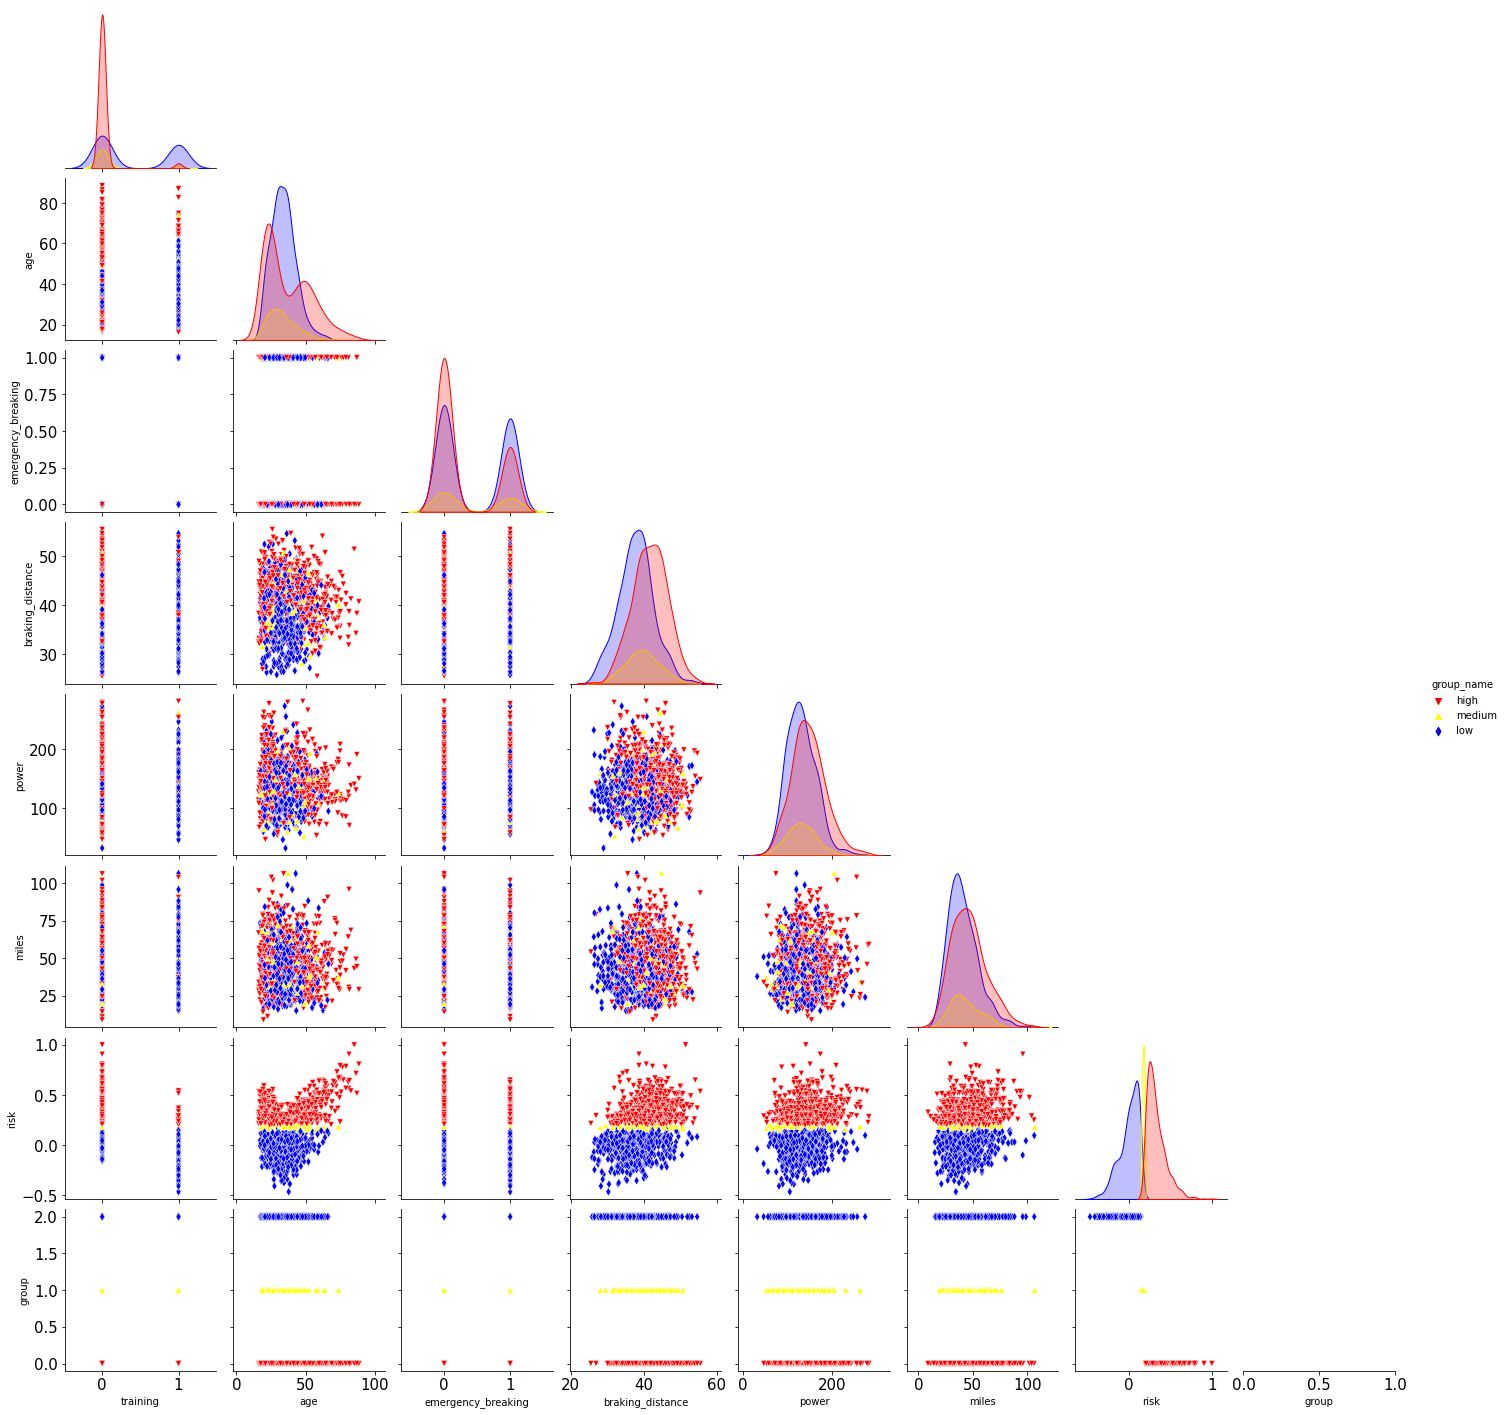

In [98]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html

# sns.pairplot(preprocessed_data, hue='group',  kind="kde";
 
sns.pairplot(preprocessed_data, 
             kind="scatter", 
             diag_kind="kde",
             corner=True, 
             hue='group_name',
             hue_order = ['high', 'medium', 'low'],
             palette=colors, 
             markers=markers);


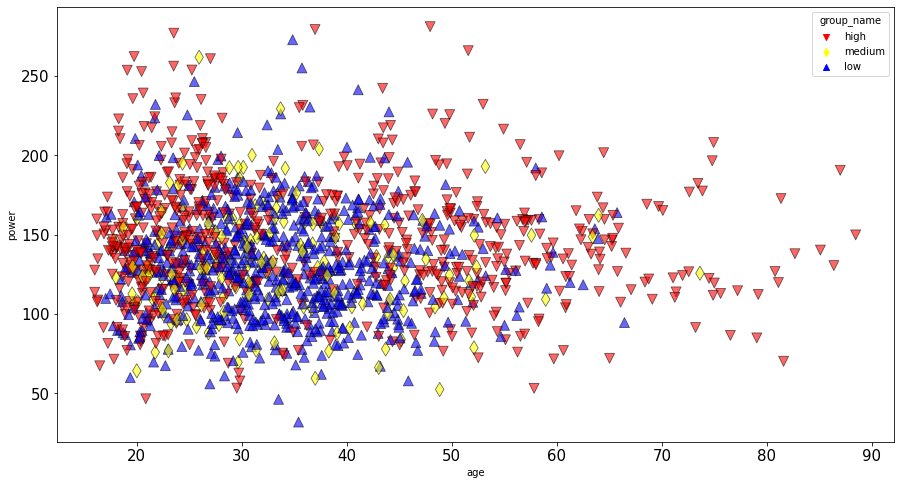

In [99]:
sns.scatterplot(preprocessed_data['age'], 
                preprocessed_data['power'], 
                hue=preprocessed_data['group_name'], 
                hue_order = ['high', 'medium', 'low'],
                palette=colors,  
                style=preprocessed_data['group_name'],
                style_order = ['high', 'medium', 'low'],
                markers=markers,
                s=100,
                edgecolor='k',
                alpha=0.6
               );

In [100]:
file_name = './model-based-1.csv'
preprocessed_data.to_csv(file_name, index=False, sep=';')

In [101]:
!ls -l

total 2720
-rw-r--r-- 1 olli olli  141895 Jul 22 16:03 generate-causal.ipynb
-rw-r--r-- 1 olli olli 2101079 Jul 22 13:52 generate.ipynb
-rw-r--r-- 1 olli olli   54500 May  9 12:33 insurance-customers-risk-1500-shift.csv
-rw-r--r-- 1 olli olli   54435 May  9 12:33 insurance-customers-risk-1500-test.csv
-rw-r--r-- 1 olli olli   54421 Jul 22 13:21 insurance-customers-risk-1500.csv
-rw-r--r-- 1 olli olli  156270 Jul 22 16:03 model-based-1.csv
-rw-r--r-- 1 olli olli  177561 Jul 22 13:27 stats-basics.ipynb
-rw-r--r-- 1 olli olli   28306 Jul 21 16:31 stats-causal.ipynb


In [102]:
customers = pd.read_csv(file_name, sep=';')
customers.describe()

training          age  emergency_breaking  braking_distance  \
count  1500.000000  1500.000000         1500.000000       1500.000000   
mean      0.207333    35.243806            0.384667         39.728535   
std       0.405532    13.193059            0.486679          5.108156   
min       0.000000    16.000000            0.000000         25.502431   
25%       0.000000    24.971581            0.000000         36.261921   
50%       0.000000    32.511926            0.000000         39.697162   
75%       0.000000    43.043168            1.000000         43.284010   
max       1.000000    88.456666            1.000000         55.491497   

             power        miles         risk     group  
count  1500.000000  1500.000000  1500.000000  1500.000  
mean    137.524885    43.766704     0.166736     1.000  
std      36.527189    15.274232     0.193054     0.949  
min      31.956980     8.911590    -0.466122     0.000  
25%     112.369662    32.597446     0.042936     0.000  
50%     134.053456    41.697948     0.174691     1.000  
75%     160.117914    52.330167     0.285114     2.000  
max     281.197004   106.746630     1.000000     2.000

# Story: Assistant systems get more and more important, bringing down weight on driver ability and bringen up breaking systems over time 
* influence on driver ability can not be measured in input
* but inputs like age and assistant system

In [103]:
def generate_risk_data(driver_weight = 4.0, 
                       emergency_breaking_fraction = 0.40,
                       age_drift = 0,
                       n_samples=1_500, 
                       seed=42,
#                        apply_norm=True,
                       apply_norm=False,
                       low_risk_threshold = 1.0,
                       high_risk_threshold = 3.0,
                      low_risk_quantile=.3333,
                      high_risk_quantile=.6666):
    risk_model = StructuralCausalModel({
        "training": lambda n_samples: np.random.binomial(1, p=0.20, size=n_samples), 
    #     "age": lambda n_samples: np.clip(skewnorm.rvs(a=16, loc=age_mean, scale=age_std, size=n_samples), a_min=16, a_max=100).astype(int),
        "age": lambda n_samples: np.clip(skewnorm.rvs(a=16, loc=age_mean, scale=age_std, size=n_samples), a_min=16, a_max=100) \
            + np.random.normal(age_drift, scale=0.1, size=n_samples),
        "driver_ability": \
            lambda training, age, n_samples: 
                np.random.normal(loc=training - \
                                 # all deviation from good age is negative
                                 # using unskwed mean makes this a bit more balanaced
                                 abs(age - age_skewed_mean) / age_std, \
                                 scale=0.1),
        "emergency_breaking": lambda n_samples: np.random.binomial(1, p=emergency_breaking_fraction, size=n_samples), 
        "braking_distance": lambda n_samples: np.random.normal(loc=braking_distance_mean, scale=braking_distance_std, size=n_samples),
        "power": lambda n_samples: skewnorm.rvs(a=2, loc=power_mean, scale=power_std, size=n_samples),
        "car_safety": \
            lambda emergency_breaking, braking_distance, power, n_samples: \
                np.random.normal(loc=emergency_breaking - \
                                 # having a breaking distance below average is negative, so we have to subtract
                                 (braking_distance - braking_distance_mean) / braking_distance_std - \
                                 # all deviation from good amount of power is negative
                                 abs(power - power_mean) / power_std, \
                                 scale=0.1),
        "miles": lambda n_samples: skewnorm.rvs(a=4, loc=miles_mean, scale=miles_std, size=n_samples),
        "risk": \
            lambda driver_ability, car_safety, miles, n_samples:
                    # negative score is high risk
                    # driver is overall more important than car
                 - np.random.normal(loc=\
                                 driver_ability * driver_weight\
                                 + car_safety
                                 # all deviation from good miles is negative
                                 - abs(miles - miles_mean) / miles_std, \
                                 scale=0.1)})
    np.random.seed(seed)
    data = risk_model.sample(n_samples=n_samples)
    
    preprocessed_data = data[features]
    # preprocessed_data = data.copy()
    if apply_norm:
        preprocessed_data['risk'] = normalize(preprocessed_data['risk'].values.reshape(-1, 1), axis=0, norm='max')
    preprocessed_data['group_name'] = 'medium'
    preprocessed_data['group'] = YELLOW
    
    if low_risk_threshold is None:
        low_risk_threshold = preprocessed_data['risk'].quantile(low_risk_quantile)
        high_risk_threshold = preprocessed_data['risk'].quantile(high_risk_quantile)

    preprocessed_data['group_name'] = np.where(preprocessed_data['risk'] < low_risk_threshold, 'low', preprocessed_data['group_name'])
    preprocessed_data['group_name'] = np.where(preprocessed_data['risk'] > high_risk_threshold, 'high', preprocessed_data['group_name'])

    preprocessed_data['group'] = np.where(preprocessed_data['group_name'] == 'low', GREEN, preprocessed_data['group'])
    preprocessed_data['group'] = np.where(preprocessed_data['group_name'] == 'high', RED, preprocessed_data['group'])
    
    return preprocessed_data


In [104]:
generated_data = generate_risk_data()
generated_data.describe()

training          age  emergency_breaking  braking_distance  \
count  1500.000000  1500.000000         1500.000000       1500.000000   
mean      0.207333    35.240226            0.370000         40.047327   
std       0.405532    13.191571            0.482965          5.292310   
min       0.000000    16.019190            0.000000         20.816722   
25%       0.000000    24.948022            0.000000         36.440032   
50%       0.000000    32.462481            0.000000         39.922413   
75%       0.000000    43.078459            1.000000         43.675832   
max       1.000000    88.425701            1.000000         57.645276   

             power        miles         risk        group  
count  1500.000000  1500.000000  1500.000000  1500.000000  
mean    134.393736    44.012633     2.263072     0.896667  
std      33.410677    15.954862     2.613310     0.826909  
min      45.272791    11.367135    -6.991965     0.000000  
25%     110.333073    32.366821     0.712746     0.000000  
50%     132.423028    41.403469     2.369354     1.000000  
75%     155.296864    53.146008     3.937852     2.000000  
max     257.983238   109.315794    12.307638     2.000000

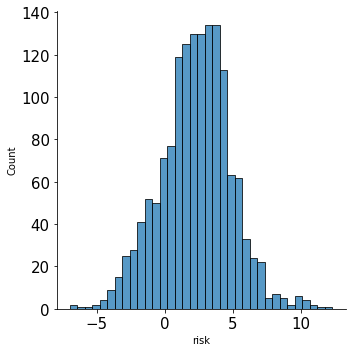

In [105]:
sns.displot(generated_data["risk"]);

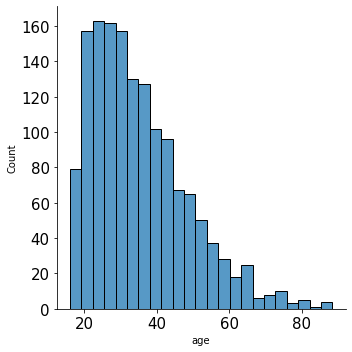

In [106]:
sns.displot(generated_data["age"]);

In [107]:
np.unique(generated_data['group_name'], return_counts=True)

(array(['high', 'low', 'medium'], dtype=object), array([598, 443, 459]))

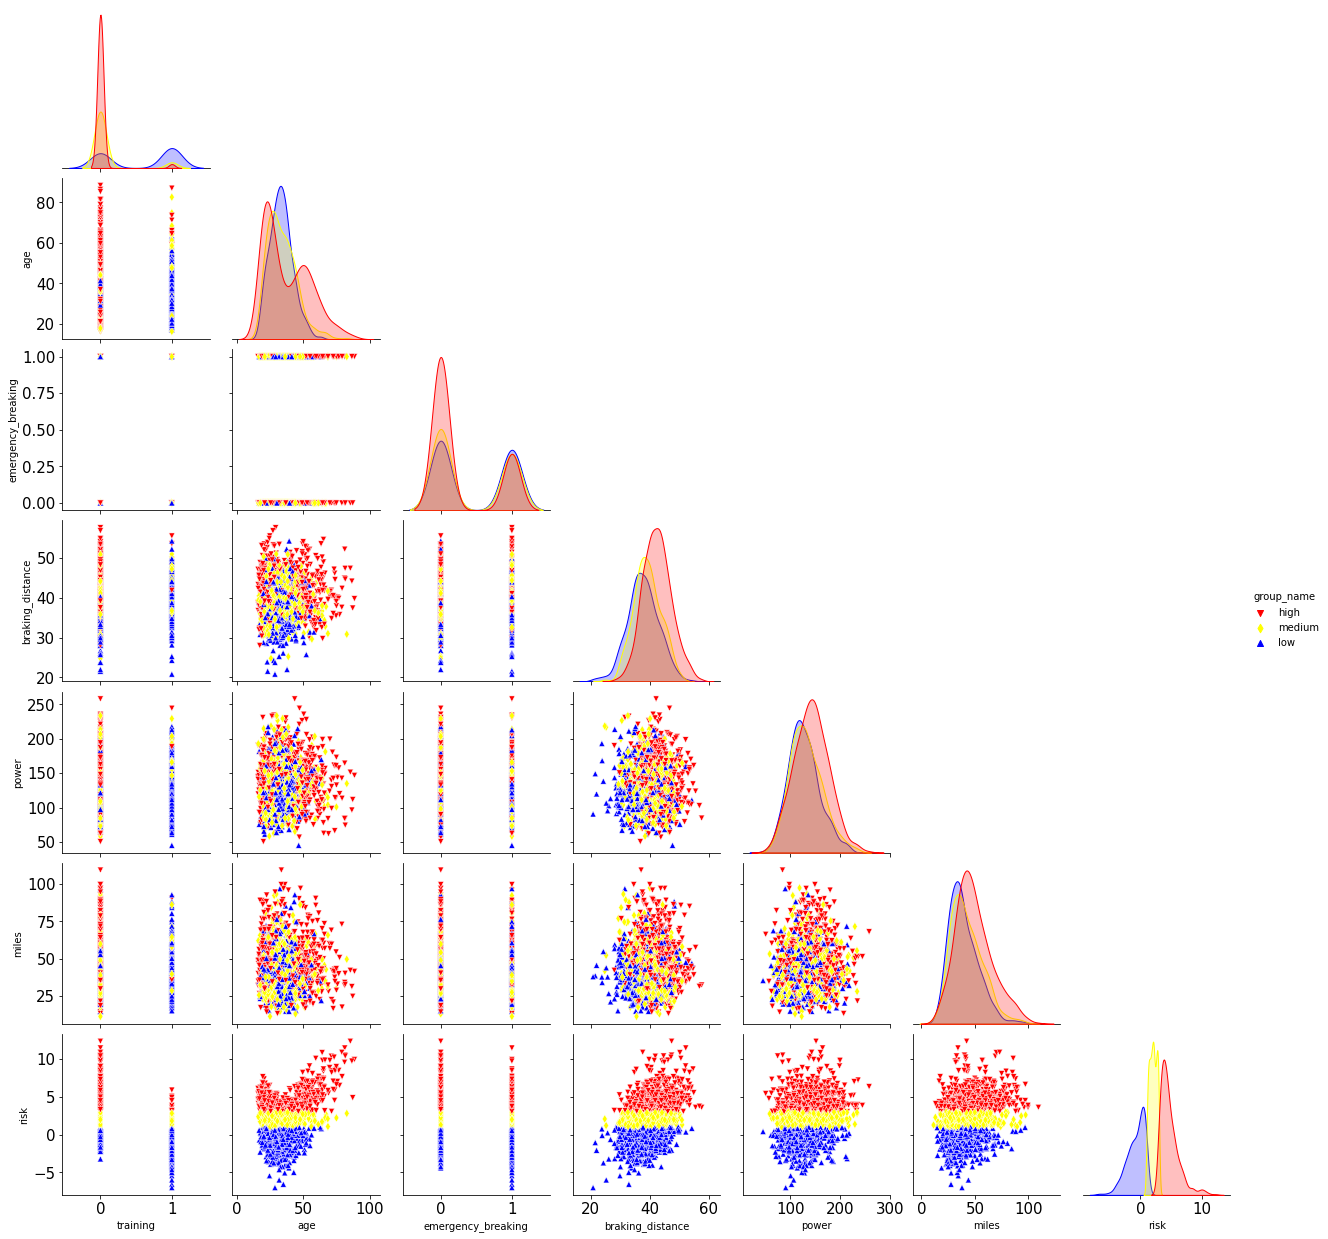

In [108]:
sns.pairplot(generated_data, 
             kind="scatter", 
             diag_kind="kde",
             corner=True, 
             hue='group_name',
             hue_order = ['high', 'medium', 'low'],
             palette=colors, 
             markers=markers,
             vars=features);

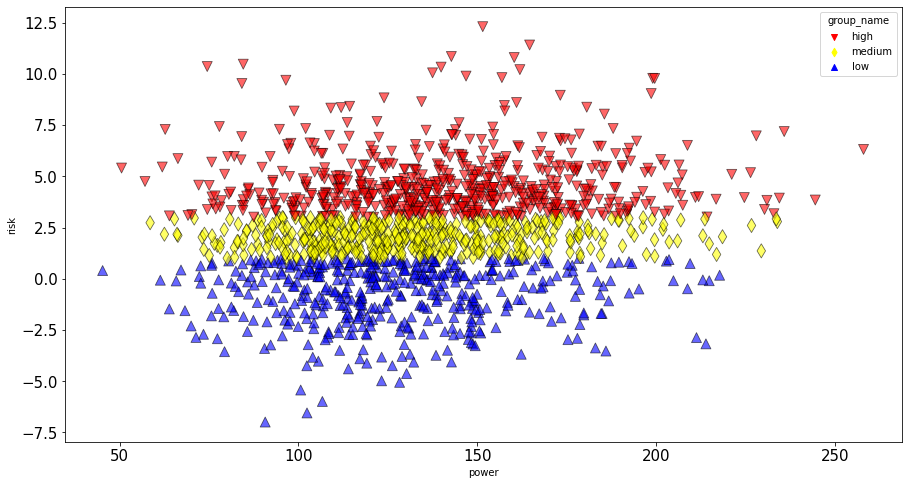

In [109]:
sns.scatterplot(generated_data['power'], 
                generated_data['risk'], 
                hue=generated_data['group_name'], 
                hue_order = ['high', 'medium', 'low'],
                palette=colors,  
                style=generated_data['group_name'], 
                style_order = ['high', 'medium', 'low'],
                markers=markers,
                s=100,
                edgecolor='k',
                alpha=0.6
               );

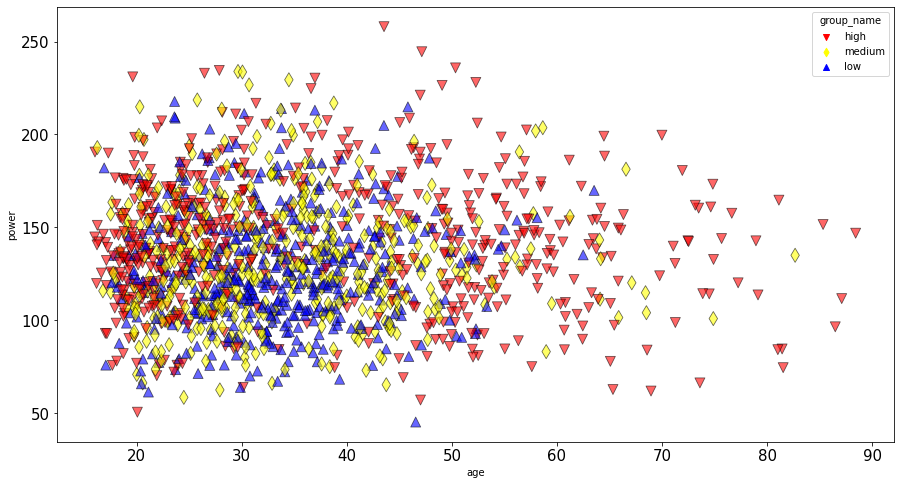

In [110]:
sns.scatterplot(generated_data['age'], 
                generated_data['power'], 
                hue=generated_data['group_name'], 
                hue_order = ['high', 'medium', 'low'],
                palette=colors,  
                style=generated_data['group_name'], 
                style_order = ['high', 'medium', 'low'],
                markers=markers,
                s=100,
                edgecolor='k',
                alpha=0.6
               );

In [111]:
gen_1 = generated_data

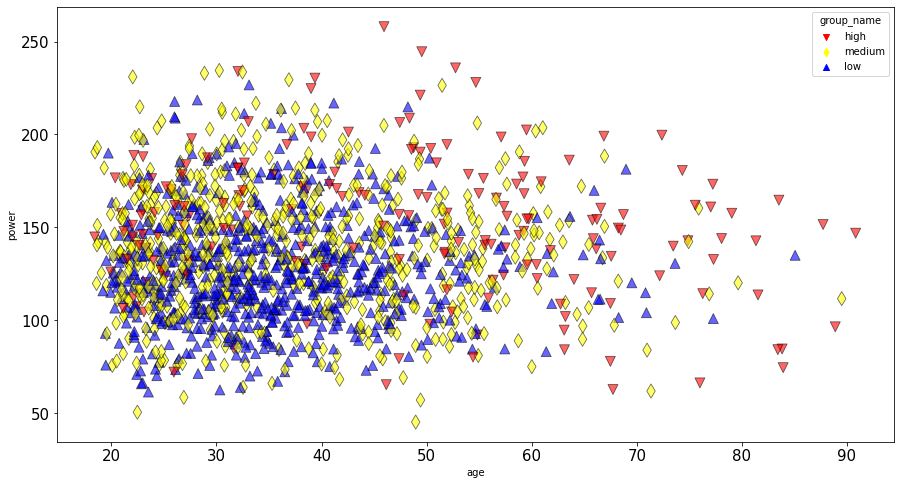

In [112]:
iteration = 24

generated_data = generate_risk_data(driver_weight = 4.0 - iteration * 0.1,
                                    age_drift = iteration * 0.1,
                                    emergency_breaking_fraction = 0.40 + iteration * 0.02)
sns.scatterplot(generated_data['age'], 
                generated_data['power'], 
                hue=generated_data['group_name'], 
                hue_order = ['high', 'medium', 'low'],
                palette=colors,  
                style=generated_data['group_name'], 
                style_order = ['high', 'medium', 'low'],
                markers=markers,
                s=100,
                edgecolor='k',
                alpha=0.6
               );

In [113]:
np.unique(generated_data['group_name'], return_counts=True)

(array(['high', 'low', 'medium'], dtype=object), array([181, 716, 603]))

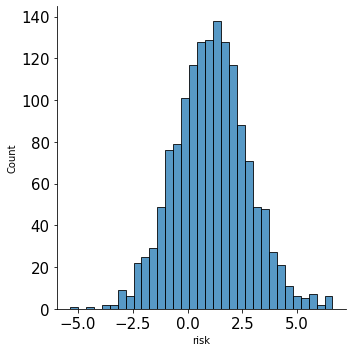

In [114]:
sns.displot(generated_data["risk"]);

In [115]:
generated_data.describe()

training          age  emergency_breaking  braking_distance  \
count  1500.000000  1500.000000         1500.000000       1500.000000   
mean      0.207333    37.640226            0.890667         40.047327   
std       0.405532    13.191571            0.312161          5.292310   
min       0.000000    18.419190            0.000000         20.816722   
25%       0.000000    27.348022            1.000000         36.440032   
50%       0.000000    34.862481            1.000000         39.922413   
75%       0.000000    45.478459            1.000000         43.675832   
max       1.000000    90.825701            1.000000         57.645276   

             power        miles         risk        group  
count  1500.000000  1500.000000  1500.000000  1500.000000  
mean    134.393736    44.012633     1.085830     1.356667  
std      33.410677    15.954862     1.674250     0.686369  
min      45.272791    11.367135    -5.371777     0.000000  
25%     110.333073    32.366821    -0.017934     1.000000  
50%     132.423028    41.403469     1.091746     1.000000  
75%     155.296864    53.146008     2.119230     2.000000  
max     257.983238   109.315794     6.610328     2.000000

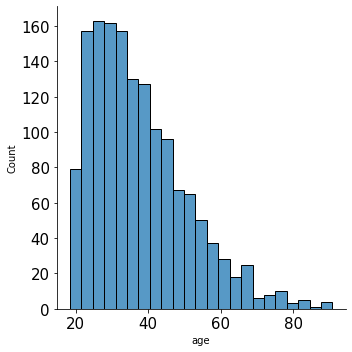

In [116]:
sns.displot(generated_data["age"]);

In [117]:
generated_data["age"].describe()

count    1500.000000
mean       37.640226
std        13.191571
min        18.419190
25%        27.348022
50%        34.862481
75%        45.478459
max        90.825701
Name: age, dtype: float64

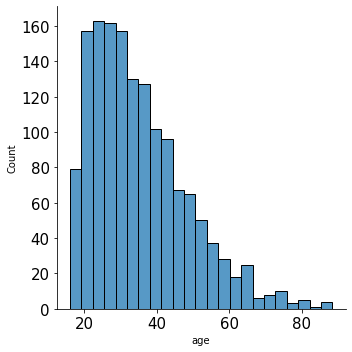

In [118]:
sns.displot(gen_1["age"]);

In [119]:
gen_1["age"].describe()

count    1500.000000
mean       35.240226
std        13.191571
min        16.019190
25%        24.948022
50%        32.462481
75%        43.078459
max        88.425701
Name: age, dtype: float64

In [120]:
import evidently

In [121]:
import evidently.analyzers

In [122]:
evidently.analyzers?

In [123]:
from evidently.analyzers.stattests.jensenshannon import jensenshannon_stat_test
from evidently.analyzers.stattests.kl_div import kl_div_stat_test
from evidently.analyzers.stattests.ks_stattest import ks_stat_test
from evidently.analyzers.stattests.psi import psi_stat_test
from evidently.analyzers.stattests.wasserstein_distance_norm import wasserstein_stat_test

In [124]:
# !pip install evidently

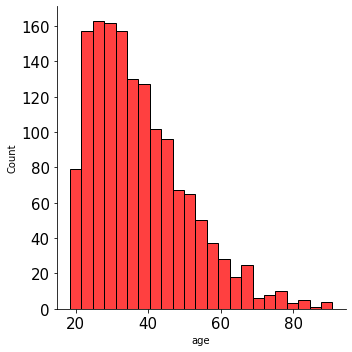

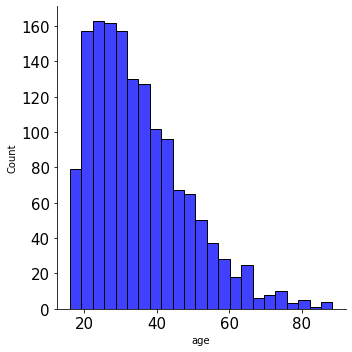

In [125]:
sns.displot(generated_data["age"], color='red');
sns.displot(gen_1["age"], color='blue');

In [126]:
ks_stat_test?

In [127]:
ks_stat_test(gen_1["age"], generated_data["age"], 'num', threshold=None)

StatTestResult(drift_score=1.2503686115967146e-05, drifted=True, actual_threshold=0.05)

In [134]:
# ks and wasserstein drift shortly after 10

In [135]:
iteration = 13

generated_data = generate_risk_data(driver_weight = 4.0 - iteration * 0.1,
                                    age_drift = iteration * 0.1,
                                    seed=iteration,
                                    emergency_breaking_fraction = 0.40 + iteration * 0.02)
wasserstein_stat_test(gen_1["age"], generated_data["age"], 'num', threshold=None)

StatTestResult(drift_score=0.1191385291393408, drifted=True, actual_threshold=0.1)

In [145]:
iteration = 11

generated_data = generate_risk_data(driver_weight = 4.0 - iteration * 0.1,
                                    age_drift = iteration * 0.1,
                                    seed=iteration,
                                    emergency_breaking_fraction = 0.40 + iteration * 0.02)
wasserstein_stat_test(gen_1["age"], generated_data["age"], 'num', threshold=None)

ks_stat_test(gen_1["age"], generated_data["age"], 'num', threshold=None)


StatTestResult(drift_score=0.0037657665795975317, drifted=True, actual_threshold=0.05)